In [1]:
import ee
import geopandas
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
from ast import literal_eval
from shapely import wkt
from shapely.geometry import box, Point, LineString, Polygon, MultiLineString
from shapely.ops import split
import math
import warnings
from matplotlib import pyplot as plt

from numpy import array
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.utils import to_categorical
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import pickle
import csv

Using TensorFlow backend.


In [2]:
# ee.Initialize()

Read in the country boundary file and randomly selected lat/lon

In [4]:
# There are in total of 6 categories
#     0: Non-croplands
#     1: Croplands: irrigation major
#     2: Croplands: irrigation minor
#     3: Croplands: rainfed
#     4: Croplands: rainfed, minor fragments
#     5: Croplands: rainfed, rainfed, very minor fragments
sentinel_df = pd.read_csv('../data/Sample_Sentinel_2018.csv', index_col=[0])
sentinel_df['lat'] = sentinel_df['lat'].round(3)
sentinel_df['lon'] = sentinel_df['lon'].round(3)
# def create_label(row):
#     if row['landcover'] == 0:
#         return 0
#     elif row['landcover'] in [1, 2]:
#         return 1
#     elif row['landcover'] in [3, 4, 5]:
#         return 2
#     else:
#         return None
def create_label(row):
    if row['landcover'] == 0:
        return None
    elif row['landcover'] in [1, 2]:
        return 1
    elif row['landcover'] in [3, 4, 5]:
        return 0
    else:
        return None
sentinel_df['label'] = sentinel_df.apply(create_label, axis=1)
sentinel_df.head()

,201801_EVI,201801_NDVI,201801_SAVI,201802_EVI,201802_NDVI,201802_SAVI,201803_EVI,201803_NDVI,201803_SAVI,201804_EVI,...,201811_NDVI,201811_SAVI,201812_EVI,201812_NDVI,201812_SAVI,country_segment_code,landcover,lat,lon,label
0,-3.177990,0.434695,0.651910,-2.155830,0.143705,0.215522,0.731757,0.177798,0.266657,-1.398783,...,0.498200,0.747166,-6.618986,0.450540,0.675686,KHM_0,0,14.139,106.360,NaN
1,-3.201427,0.447774,0.671535,-2.412143,0.493607,0.740282,-2.939160,0.536976,0.805343,-4.702053,...,0.328143,0.492147,-1.401169,0.423077,0.634431,KHM_0,0,12.016,103.226,NaN
2,0.441103,0.168044,0.252025,-1.948273,0.209628,0.314393,-1.510097,0.219080,0.328573,-88.341848,...,0.523226,0.784739,37.076897,0.548827,0.823129,KHM_0,3,12.517,105.373,0.0
3,-4.601671,0.662005,0.992860,-2.546674,0.604884,0.907192,-3.379477,0.549187,0.823674,-4.602324,...,0.452731,0.678988,-7.432097,0.444197,0.666213,KHM_0,4,12.280,102.655,0.0
4,12.719153,0.246539,0.369751,-1.422424,0.223287,0.334891,0.192333,0.162724,0.244066,4.276400,...,0.568106,0.852000,-6.192888,0.456797,0.685105,KHM_0,3,10.874,104.658,0.0


In [4]:
climate_df = pd.read_csv('../data/Sample_TerraClimate_2018.csv', index_col=[0]).dropna()
climate_df['lat'] = climate_df['lat'].round(3)
climate_df['lon'] = climate_df['lon'].round(3)
# climate_df.shape
climate_df.head()

,201801_aet,201801_def,201801_pdsi,201801_pet,201801_pr,201801_ro,201801_soil,201801_srad,201801_swe,201801_tmmn,...,201812_srad,201812_swe,201812_tmmn,201812_tmmx,201812_vap,201812_vpd,201812_vs,country_segment_code,lat,lon
0,0.0,0.0,200.0,0.0,2.0,0.0,100.0,6.0,41.0,-406.0,...,0.0,46.0,-385.0,-324.0,46.0,-2.0,270.0,CAN_23,79.478,-86.660
1,0.0,0.0,320.0,0.0,2.0,0.0,246.0,5.0,37.0,-378.0,...,0.0,44.0,-356.0,-293.0,40.0,0.0,310.0,CAN_23,79.327,-87.898
3,780.0,0.0,220.0,780.0,120.0,42.0,1966.0,1543.0,0.0,161.0,...,1958.0,0.0,171.0,259.0,2202.0,61.0,150.0,HND_0,15.523,-88.367
4,611.0,329.0,150.0,940.0,26.0,1.0,1357.0,1848.0,0.0,118.0,...,2030.0,0.0,132.0,225.0,1607.0,55.0,270.0,HND_0,14.158,-87.255
5,670.0,684.0,-10.0,1354.0,4.0,0.0,1307.0,2091.0,0.0,158.0,...,2176.0,0.0,170.0,302.0,2044.0,113.0,210.0,HND_0,14.035,-88.304


In [5]:
merge_raw_df = pd.merge(sentinel_df,climate_df,on=['country_segment_code', 'lat', 'lon'])
merge_raw_df.shape

(15115, 209)

In [6]:
merge_raw_df = merge_raw_df.dropna()
merge_raw_df.shape
# standardize columns

(8709, 209)

In [160]:
merge_raw_df2 = merge_raw_df.loc[:, ~(merge_raw_df.columns.str.contains('EVI') | merge_raw_df.columns.str.contains('SAVI'))]

In [161]:
merge_standardized_df = merge_raw_df2.copy()
feature_lst = ['NDVI', 'aet', 'def', 'pdsi', 'pet', 'pr', 'ro', 'soil', 'srad', 'swe', 'tmmn', 'tmmx', 'vap', 'vpd', 'vs']
first_ind = 0
feature_mean_lst = []
feature_std_lst = []
for feat in feature_lst:
    temp_df = merge_raw_df.loc[:, merge_raw_df.columns.str.contains(feat)]
    feature_mean = temp_df.mean().mean()
    feature_mean_lst.append(feature_mean)
    feature_std = temp_df.stack().std()
    feature_std_lst.append(feature_std)
    for col in list(temp_df.columns):
        merge_standardized_df[col] = (temp_df[col]-feature_mean)/feature_std

In [167]:
with open('Model_prep_mean.csv', 'wt') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(feature_mean_lst)
with open('Model_prep_std.csv', 'wt') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(feature_std_lst)

In [162]:
merge_standardized_df.head()

,201801_NDVI,201802_NDVI,201803_NDVI,201804_NDVI,201805_NDVI,201806_NDVI,201807_NDVI,201808_NDVI,201809_NDVI,201810_NDVI,...,201812_pr,201812_ro,201812_soil,201812_srad,201812_swe,201812_tmmn,201812_tmmx,201812_vap,201812_vpd,201812_vs
1,-0.479873,-0.282284,-0.237369,0.241782,-0.576104,-0.739452,0.302756,0.773048,1.327450,1.431351,...,-0.668115,-0.279674,5.155439,0.058329,-0.237908,1.110882,0.797531,1.768175,0.143156,-1.036179
2,1.867232,1.595813,1.331167,1.076423,1.717627,0.817969,-0.548237,-0.652149,0.552810,1.083482,...,-0.565213,-0.279674,2.536472,-0.196961,-0.237908,1.181342,0.928081,1.777161,0.110501,-0.592967
4,0.810523,0.088876,-0.461016,-0.540054,-0.138716,0.598715,-0.703709,-0.334411,1.543470,-0.401321,...,-0.513763,-0.279674,2.349510,-0.245259,-0.237908,1.198956,0.764893,1.818240,-0.357559,-1.568033
7,-1.350348,-0.956977,-0.573143,-1.249977,-0.901362,-1.428536,-1.897891,-2.147297,-1.455186,-3.416567,...,-0.590939,-0.279674,4.403070,0.025211,-0.237908,1.163727,0.822009,1.792566,0.154041,-1.479391
20,0.930570,1.503744,1.225845,1.325926,1.963657,0.911215,0.075750,1.528966,2.303226,2.188087,...,-0.333685,-0.258821,5.092113,-0.191441,-0.237908,1.216571,0.789371,1.556365,-0.270478,-1.302106


In [132]:
merge_standardized_df['label'].value_counts()

0.0    4523
1.0    4186
Name: label, dtype: int64

LSTM

In [133]:
x_columns = list(merge_standardized_df.columns)
x_columns.remove('country_segment_code')
x_columns.remove('landcover')
x_columns.remove('label')
x_columns.remove('lat')
x_columns.remove('lon')
x_columns.sort()

In [173]:
x_columns

['201801_NDVI',
 '201801_aet',
 '201801_def',
 '201801_pdsi',
 '201801_pet',
 '201801_pr',
 '201801_ro',
 '201801_soil',
 '201801_srad',
 '201801_swe',
 '201801_tmmn',
 '201801_tmmx',
 '201801_vap',
 '201801_vpd',
 '201801_vs',
 '201802_NDVI',
 '201802_aet',
 '201802_def',
 '201802_pdsi',
 '201802_pet',
 '201802_pr',
 '201802_ro',
 '201802_soil',
 '201802_srad',
 '201802_swe',
 '201802_tmmn',
 '201802_tmmx',
 '201802_vap',
 '201802_vpd',
 '201802_vs',
 '201803_NDVI',
 '201803_aet',
 '201803_def',
 '201803_pdsi',
 '201803_pet',
 '201803_pr',
 '201803_ro',
 '201803_soil',
 '201803_srad',
 '201803_swe',
 '201803_tmmn',
 '201803_tmmx',
 '201803_vap',
 '201803_vpd',
 '201803_vs',
 '201804_NDVI',
 '201804_aet',
 '201804_def',
 '201804_pdsi',
 '201804_pet',
 '201804_pr',
 '201804_ro',
 '201804_soil',
 '201804_srad',
 '201804_swe',
 '201804_tmmn',
 '201804_tmmx',
 '201804_vap',
 '201804_vpd',
 '201804_vs',
 '201805_NDVI',
 '201805_aet',
 '201805_def',
 '201805_pdsi',
 '201805_pet',
 '201805_pr

In [185]:
x_df = merge_standardized_df[x_columns]
y_df = merge_standardized_df['label']
X_train, X_test, y_train, y_test = train_test_split(x_df.values, y_df.values, test_size=0.3, random_state=210, stratify=y_df.values)
X_train2 = np.transpose(X_train.reshape(X_train.shape[0], 15, 12), axes=[0, 2, 1])
X_test2 = np.transpose(X_test.reshape(X_test.shape[0], 15, 12), axes=[0, 2, 1])
# y_01_arr = to_categorical(y_arr)

In [202]:
# define model
model = Sequential()
# model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(12, 17)))
# model.add(LSTM(50, activation='relu'))
model.add(LSTM(50, activation='relu', input_shape=(12, 15)))
model.add(Dropout(0.3))
# model.add(Dense(20, activation='relu'))
# model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
opt = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 50)                13200     
_________________________________________________________________
dropout_31 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 51        
Total params: 13,251
Trainable params: 13,251
Non-trainable params: 0
_________________________________________________________________


In [203]:
history = model.fit(X_train2, y_train, validation_data=(X_test2, y_test), epochs=30, batch_size=16)

Train on 6096 samples, validate on 2613 samples
Epoch 1/30
6096/6096 [==============================] - 3s 477us/step - loss: 0.6861 - accuracy: 0.5520 - val_loss: 0.6699 - val_accuracy: 0.5897
Epoch 2/30
6096/6096 [==============================] - 3s 422us/step - loss: 0.6740 - accuracy: 0.5784 - val_loss: 0.6600 - val_accuracy: 0.6089
Epoch 3/30
6096/6096 [==============================] - 3s 415us/step - loss: 0.6656 - accuracy: 0.5928 - val_loss: 0.6568 - val_accuracy: 0.6051
Epoch 4/30
6096/6096 [==============================] - 3s 411us/step - loss: 0.6561 - accuracy: 0.6097 - val_loss: 0.6529 - val_accuracy: 0.6162
Epoch 5/30
6096/6096 [==============================] - 3s 417us/step - loss: 0.6492 - accuracy: 0.6186 - val_loss: 0.6464 - val_accuracy: 0.6215
Epoch 6/30
6096/6096 [==============================] - 3s 417us/step - loss: 0.6452 - accuracy: 0.6212 - val_loss: 0.6409 - val_accuracy: 0.6334
Epoch 7/30
6096/6096 [==============================] - 3s 420us/step - loss

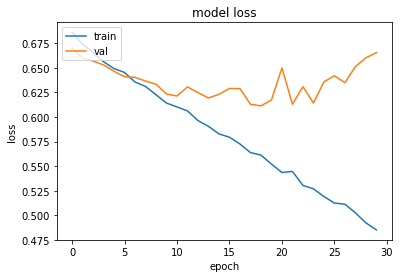

In [204]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

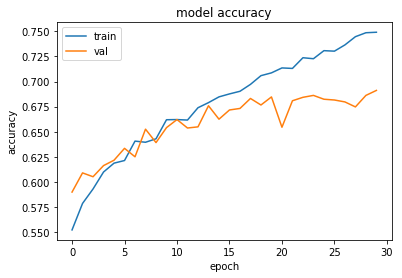

In [205]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# model.save('Model_LSTM.h5')

In [ ]:
predictions = model.predict(x_arr[:3])

GBM

In [168]:
clf = GradientBoostingClassifier(random_state=0)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.6754688097971681

In [169]:
clf.predict(X_test[:2])

array([1., 0.])

In [170]:
# Save to file in the current working directory
pkl_filename = "Model_GBM.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clf, file)

# Load from file
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)
    
# Calculate the accuracy score and predict target values
score = pickle_model.score(X_test, y_test)
print("Test score: {0:.2f} %".format(100 * score))
# Ypredict = pickle_model.predict(X_test)

Test score: 67.55 %


Random Forest

In [153]:
clf = RandomForestClassifier(max_depth=20, criterion="entropy", min_samples_split=10, min_samples_leaf=5, 
                             max_samples=0.5, max_features=10, n_estimators=100, random_state=0)
# clf = RandomForestClassifier(max_depth=20, criterion="entropy", min_samples_split=10, min_samples_leaf=5, 
#                              random_state=0)
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.8987860892388452
0.7129735935706085


In [154]:
clf.predict(X_test[:2])

array([0., 0.])

In [155]:
# Save to file in the current working directory
pkl_filename = "Model_RF.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clf, file)

# Load from file
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)
    
# Calculate the accuracy score and predict target values
score = pickle_model.score(X_test, y_test)
print("Test score: {0:.2f} %".format(100 * score))
# Ypredict = pickle_model.predict(X_test)

Test score: 71.30 %


Logistic Regression

In [41]:
clf = LogisticRegression(random_state=0)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.6410256410256411

In [42]:
clf.predict(X_test[:2])

array([0., 1.])